<img src="Imagens/Rio1.png"/>

# Transferência de estilo

Antes de realizar um processo de transferência de estilo, vamos deixar claro que de fato isto é.

Transferência de estilo é um **processo de modificar o estilo de uma imagem e, ao mesmo tempo, preservar o seu conteúdo**. O artigo que define todo este processo pode ser visto em https://arxiv.org/pdf/1508.06576.pdf.

Um exemplo simples, pode ser visto na figura abaixo. (ref: https://www.techleer.com/articles/466-insight-into-fast-style-transfer-in-tensorflow/)

<img src="Imagens/ex1.jpg"/>

Desta forma, a ideia é simples. Há uma imagem de entrada e uma imagem de estilo. A saída será a sua imagem de entrada estilizada. Ou seja:

- Entrada + Estilo -> Entrada estilizada

Vamos programar uma rede neural, passo a passo, para fazer a transferência de estilo. Vamos começar importando algumas bibliotecas.

#### Imporantando bibliotecas

In [14]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from keras import backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

#### Definindo alguns parâmetros

In [18]:
media_rgb_imagenet = [123.68, 116.779, 103.939] # Média dos valores RGB das imagens do ImageNet
peso_conteudo = 0.02
peso_estilo = 4.5
variacao_peso = 0.995
variacao_fator_custo = 1.25
largura_imagem = 500
altura_imagem = 750
canais = 3 # R G B

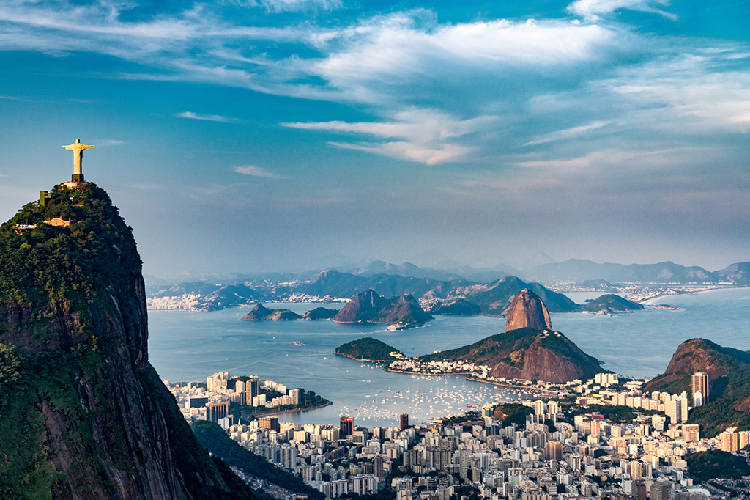

In [20]:
# Lendo imagem de entrada e colocando no tamanho padrão escolhido (500x750)
img_entrada = Image.open('Imagens/Rio1.png')
img_entrada = img_entrada.resize((altura_imagem,largura_imagem))
img_entrada.save('entrada.png')
img_entrada

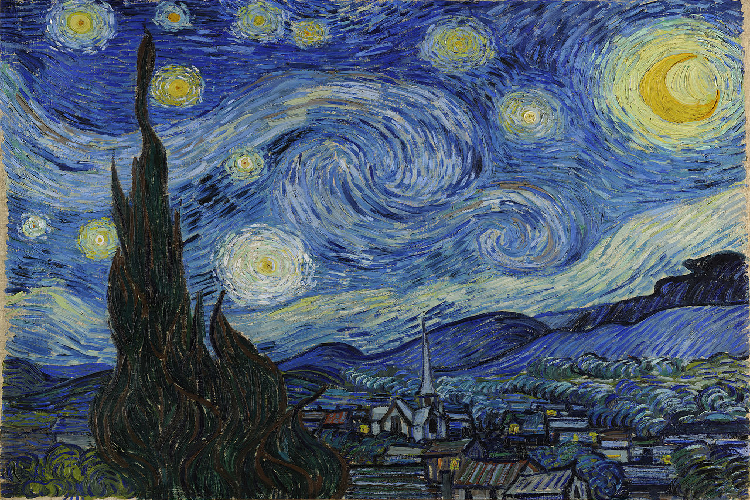

In [21]:
# Lendo imagem de estilo e colocando no tamanho padrão escolhido (500x750)
img_estilo = Image.open('Imagens/starry_night.jpg')
img_estilo = img_estilo.resize((altura_imagem,largura_imagem))
img_estilo.save('entrada.png')
img_estilo

#### Normalização pela média e transformação de RGB para BGR

In [23]:
img_entrada_arr = np.asarray(img_entrada, dtype="float32") # shape = (largura_imagem, altura_imagem, canais)
img_entrada_arr = np.expand_dims(img_entrada_arr, axis=0) # shape = (1, largura_imagem, altura_imagem, canais)
img_entrada_arr[:, :, :, 0] -= media_rgb_imagenet[2]
img_entrada_arr[:, :, :, 1] -= media_rgb_imagenet[1]
img_entrada_arr[:, :, :, 2] -= media_rgb_imagenet[0]
img_entrada_arr = img_entrada_arr[:, :, :, ::-1] # Troca RGB por BGR

img_estilo_arr = np.asarray(img_estilo, dtype="float32") # shape = (largura_imagem, altura_imagem, canais)
img_estilo_arr = np.expand_dims(img_estilo_arr, axis=0) # shape = (1, largura_imagem, altura_imagem, canais)
img_estilo_arr[:, :, :, 0] -= media_rgb_imagenet[2]
img_estilo_arr[:, :, :, 1] -= media_rgb_imagenet[1]
img_estilo_arr[:, :, :, 2] -= media_rgb_imagenet[0]
img_estilo_arr = img_estilo_arr[:, :, :, ::-1] # Troca RGB por BGR

## Modelo da Rede Neural

Vamos usar um modelo pré-treinado de Rede Neural Convolucional (CNN), a VGG-16. Este modelo é a escolha certa para o processamento de imagens. Além disso, nos permite extrair separadamente o conteúdo e o estilo de uma imagem, e é exatamente isso que queremos. Então, passaremos as duas imagens pelo VGG e inicializaremos a imagem a ser gerada em uma imagem aleatória.

<img src="Imagens/vgg16.png"/>

In [ ]:
entrada = K.variable(img_entrada_arr)
estilo = K.variable(img_estilo_arr)
imagem_combinada = K.placeholder((1, largura_imagem, altura_imagem, canais))

input_tensor = K.concatenate([entrada, estilo, imagem_combinada], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)